# What is Recurrent Neural Network (RNN) ?
A Recurrent Neural Network (RNN) is a type of neural network designed to process sequences of data — like text, speech, or time-series — by using an internal memory. Unlike standard neural networks, an RNN can use information from earlier in the sequence to influence later predictions, making it good for tasks where order and context matter, such as language translation, speech recognition, or predicting stock prices.

An embedding is a way to represent data (like words, categories, or images) as vectors of numbers in a continuous, lower-dimensional space, capturing semantic meaning and relationships.

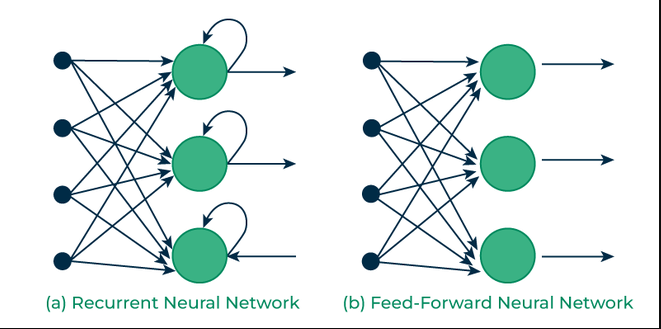

In [2]:
import pandas as pd

df = pd.read_csv('100_Unique_QA_Dataset.csv')

df.head()

,question,answer
0,What is the capital of France?,Paris
1,What is the capital of Germany?,Berlin
2,Who wrote 'To Kill a Mockingbird'?,Harper-Lee
3,What is the largest planet in our solar system?,Jupiter
4,What is the boiling point of water in Celsius?,100


In [3]:
# Tokenize
def tokenize(text):
  text = text.lower()
  text = text.replace('?','')
  text = text.replace("'","")
  return text.split()

In [4]:
tokenize('What is the capital of France?')

['what', 'is', 'the', 'capital', 'of', 'france']

In [5]:
# Vocabulary - <UNK> here means unknown word
vocab = {'<UNK>':0}

In [6]:
def build_vocab(row):

  tokenized_question = tokenize(row['question'])
  tokenized_answer = tokenize(row['answer'])

  merged_tokens = tokenized_question + tokenized_answer

  for token in merged_tokens:

    if token not in vocab:
      vocab[token] = len(vocab)


In [7]:
df.apply(build_vocab, axis=1)

,0
0,None
1,None
2,None
3,None
4,None
...,...
85,None
86,None
87,None
88,None


In [8]:
# Convert Words to Numerical Indices
def text_to_indices(text, vocab):

  indexed_text = []

  for token in tokenize(text):

    if token in vocab:
      indexed_text.append(vocab[token])
    else:
      indexed_text.append(vocab['<UNK>'])

  return indexed_text

In [11]:
text_to_indices("What is at0m", vocab) # See at0m is giving 0 because it doesn't exist

[1, 2, 0]

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

In [15]:
# Define a custom PyTorch Dataset class for Question-Answer pairs
class QADataset(Dataset):
    """
    A custom PyTorch Dataset that converts text Q&A pairs into numerical tensors.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing 'question' and 'answer' columns with text data
    vocab : dict
        Vocabulary mapping words to their corresponding integer indices
    """
    def __init__(self, df, vocab):
      self.df = df
      self.vocab = vocab

    def __len__(self):
     return self.df.shape[0]

    def __getitem__(self, index):

      numerical_question = text_to_indices(self.df.iloc[index]['question'], self.vocab)
      numerical_answer = text_to_indices(self.df.iloc[index]['answer'], self.vocab)

      return torch.tensor(numerical_question), torch.tensor(numerical_answer)

In [16]:
dataset = QADataset(df, vocab)

In [17]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [18]:
for question, answer in dataloader:
  print(question, answer[0])

tensor([[ 1,  2,  3,  4,  5, 53]]) tensor([54])
tensor([[78, 79, 80, 81, 82, 83, 84]]) tensor([85])
tensor([[  1,   2,   3,  17, 115,  83,  84]]) tensor([116])
tensor([[1, 2, 3, 4, 5, 6]]) tensor([7])
tensor([[ 1,  2,  3,  4,  5, 73]]) tensor([74])
tensor([[ 1,  2,  3, 69,  5, 53]]) tensor([260])
tensor([[ 10, 140,   3, 141, 270,  93, 271,   5,   3, 272]]) tensor([273])
tensor([[ 1,  2,  3, 69,  5,  3, 70, 71]]) tensor([72])
tensor([[  1,   2,   3,   4,   5, 286]]) tensor([287])
tensor([[ 10,  75, 111]]) tensor([112])
tensor([[ 42, 137,   2, 226,  12,   3, 227, 228]]) tensor([155])
tensor([[ 78,  79, 129,  81,  19,   3,  21,  22]]) tensor([36])
tensor([[ 10,   2,  62,  63,   3, 283,   5, 284]]) tensor([285])
tensor([[ 1,  2,  3, 50, 51, 19,  3, 45]]) tensor([52])
tensor([[42, 86, 87, 88, 89, 39, 90]]) tensor([91])
tensor([[ 1,  2,  3, 37, 38, 39, 40]]) tensor([41])
tensor([[ 10,  75,   3, 296,  19, 297]]) tensor([298])
tensor([[ 42, 125,   2,  62,  63,   3, 126, 127]]) tensor([128])
te

## Architecture of RNN

```
╔══════════════════════════════════════════════════════════════════════╗
║                     SIMPLE RNN ARCHITECTURE                          ║
╚══════════════════════════════════════════════════════════════════════╝

┌─────────────────────────────────────────────────────────────────────┐
│                              INPUT                                   │
│          Sequence of word indices: [23, 45, 12, 78, 34]             │
│                     Shape: (batch_size, sequence_length)            │
└──────────────────────────────────┬──────────────────────────────────┘
                                    │
                                    ▼
┌─────────────────────────────────────────────────────────────────────┐
│                         EMBEDDING LAYER                              │
│     Converts each word index to a 50-dimensional dense vector        │
│     │                                                                │
│     │  Example:                                                      │
│     │  Index 23 → [-0.12, 0.45, 0.78, ..., 0.33] (50 values)        │
│     │  Index 45 → [0.89, -0.23, 0.15, ..., -0.67] (50 values)       │
│     │  ...                                                           │
│     │                                                                │
│     Output: 3D tensor (batch, sequence_length, 50)                   │
└──────────────────────────────────┬──────────────────────────────────┘
                                    │
                                    ▼
                            [emb₁, emb₂, ..., embₙ]
                            Each: 50-dimensional
                                    │
┌───────────────────────────────────┼──────────────────────────────────┐
│           RNN CORE (50 → 64)       │                                 │
│  Processes sequence one step at a time with memory                   │
│                                                                    │
│  ┌───────┐    ┌───────┐    ┌───────┐           ┌───────┐          │
│  │  h₀   │    │  h₁   │    │  h₂   │    ...    │  hₙ   │          │
│  │(64)   │    │(64)   │    │(64)   │           │(64)   │          │
│  └───┬───┘    └───┬───┘    └───┬───┘           └───┬───┘          │
│      │            │            │                   │              │
│  ┌───▼───┐    ┌───▼───┐    ┌───▼───┐           ┌───▼───┐          │
│  │  emb₁ │    │  emb₂ │    │  emb₃ │    ...    │  embₙ │          │
│  │ (50)  │    │ (50)  │    │ (50)  │           │ (50)  │          │
│  └───────┘    └───────┘    └───────┘           └───────┘          │
│                                                                    │
│  Note: h₀ is initialized to zeros                                  │
│  Each hᵢ = f(W⋅[hᵢ₋₁, embᵢ] + b)  (RNN equation)                   │
│                                                                    │
│  Outputs:                                                          │
│  1. All hidden states: h₁...hₙ  → Shape: (batch, seq_len, 64)     │
│  2. Final hidden state: hₙ      → Shape: (batch, 1, 64)           │
└──────────────────────────────────┬──────────────────────────────────┘
                                    │
                    ┌───────────────┼───────────────┐
                    │               │               │
                    ▼               ▼               ▼
           All states ignored    Final state used
           in this architecture  for prediction
                                 │
                                 ▼
                        final.squeeze(0)
                        Remove time dimension
                                 │
                                 ▼
                         Shape: (batch, 64)
                                 │
                                 ▼
┌─────────────────────────────────────────────────────────────────────┐
│                        LINEAR (DENSE) LAYER                          │
│          Maps 64-dimensional vector to vocabulary size              │
│          │                                                          │
│          │  Example:                                                │
│          │  Input: [0.12, -0.45, 0.78, ..., 0.33] (64 values)      │
│          │  Output: [2.3, -1.5, 0.8, ..., 4.5] (vocab_size values) │
│          │                                                          │
│          Produces raw scores (logits) for each word                 │
└──────────────────────────────────┬──────────────────────────────────┘
                                    │
                                    ▼
┌─────────────────────────────────────────────────────────────────────┐
│                            OUTPUT                                    │
│       Probability distribution over entire vocabulary               │
│       Shape: (batch_size, vocab_size)                              │
│                                                                    │
│       Example (if vocab_size=10000):                               │
│       word_0: 0.001  word_1: 0.0003  word_2: 0.12 ...             │
│       word_9999: 0.004                                            │
│                                                                    │
│       Used for: Next word prediction                               │
└─────────────────────────────────────────────────────────────────────┘
```





In [22]:
import torch.nn as nn

In [23]:
class SimpleRNN(nn.Module):
    """
    Simple RNN for sequence-to-vocabulary prediction.
    Architecture: Embedding → RNN → Linear
    """

    def __init__(self, vocab_size):
        super().__init__()

        # Word to Vector: "cat" → [0.1, -0.3, 0.8, ...] (50 numbers)
        self.embedding = nn.Embedding(vocab_size, 50)

        # Sequence Processor: Reads words one by one with memory
        # 50→64: Increases dimension, capturing more complex patterns
        self.rnn = nn.RNN(50, 64, batch_first=True)  # batch_first for easier handling

        # Vocabulary Mapper: Final thought → Word probabilities
        self.fc = nn.Linear(64, vocab_size)

    def forward(self, question):
        # Step 1: Words → Numbers → Vectors
        # [23, 45, 12] → [[0.1..], [0.3..], [0.5..]] (each vector has 50 values)
        embedded_question = self.embedding(question)  # (batch, seq_len, 50)

        # Step 2: Read sequence with memory
        # hidden: All intermediate thoughts (usually discarded in this architecture)
        # final: Final thought after reading entire sequence
        hidden, final = self.rnn(embedded_question)  # final: (batch, 1, 64)

        # Step 3: Remove unnecessary dimension
        # (batch, 1, 64) → (batch, 64)
        final_state = final.squeeze(0)

        # Step 4: Thought → Word scores
        # Convert 64D thought to scores for each possible next word
        output = self.fc(final_state)  # (batch, vocab_size)

        return output

In [24]:
x = nn.Embedding(324, embedding_dim=50)
y = nn.RNN(50, 64, batch_first=True)
z = nn.Linear(64, 324)

a = dataset[0][0].reshape(1,6)
print("shape of a:", a.shape)
b = x(a)
print("shape of b:", b.shape)
c, d = y(b)
print("shape of c:", c.shape)
print("shape of d:", d.shape)

e = z(d.squeeze(0))

print("shape of e:", e.shape)

shape of a: torch.Size([1, 6])
shape of b: torch.Size([1, 6, 50])
shape of c: torch.Size([1, 6, 64])
shape of d: torch.Size([1, 1, 64])
shape of e: torch.Size([1, 324])


In [25]:
learning_rate = 0.001
epochs = 20

In [26]:
model = SimpleRNN(len(vocab))

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
# Training loop

for epoch in range(epochs):

  total_loss = 0

  for question, answer in dataloader:

    optimizer.zero_grad()

    # Forward pass
    output = model(question)

    # Loss -> output shape (1,324) - (1)
    loss = criterion(output, answer[0])

    # Gradients
    loss.backward()

    # Update
    optimizer.step()

    total_loss = total_loss + loss.item()

  print(f"Epoch: {epoch+1}, Loss: {total_loss:4f}")

Epoch: 1, Loss: 524.100012
Epoch: 2, Loss: 456.417482
Epoch: 3, Loss: 376.053907
Epoch: 4, Loss: 314.617750
Epoch: 5, Loss: 261.923339
Epoch: 6, Loss: 214.639622
Epoch: 7, Loss: 171.949737
Epoch: 8, Loss: 134.237882
Epoch: 9, Loss: 103.475484
Epoch: 10, Loss: 79.547712
Epoch: 11, Loss: 61.319285
Epoch: 12, Loss: 47.979584
Epoch: 13, Loss: 38.629493
Epoch: 14, Loss: 30.885765
Epoch: 15, Loss: 25.420037
Epoch: 16, Loss: 21.345640
Epoch: 17, Loss: 18.185892
Epoch: 18, Loss: 15.448871
Epoch: 19, Loss: 13.669858
Epoch: 20, Loss: 11.997060


In [29]:
def predict(model, question, threshold=0.5):

  # Convert question to numbers
  numerical_question = text_to_indices(question, vocab)

  # Tensor
  question_tensor = torch.tensor(numerical_question).unsqueeze(0)

  # Send to model
  output = model(question_tensor)

  # Convert logits to probs
  probs = torch.nn.functional.softmax(output, dim=1)

  # Find index of max prob
  value, index = torch.max(probs, dim=1)

  if value < threshold:
    print("I don't know")

  print(list(vocab.keys())[index])

In [30]:
predict(model, "What is the largest planet in our solar system?")

jupiter
